# Seattle_Housing_Prices_Analysis_and_Prediction

* 2019.05.11 updated 된 자료입니다.
* 집값 예측 및 분석에 대하여 정리한 자료입니다.
* 여러 사이트들을 참조하여 만든 자료로 사이트는 다음과 같습니다.
 
 분석 베이스 1 : https://www.kaggle.com/yeonmin/default-eda-stacking-introduction
   
 분석 베이스 2 : https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
 
 지리 정보 : https://becominghuman.ai/good-feature-building-techniques-tricks-for-kaggle-my-kaggle-code-repository-c953b934f1e6
 
 시간 정보 : https://bigdatascientistblog.wordpress.com/2015/10/07/feature-engineering-with-dates-ii-merging-data-from-public-sources-like-holidays/
 



#### 사용되는 패키지

In [380]:
# 패키지 import
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import time
from datetime import datetime, timedelta,date

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans

#### 각종 이용되는 함수들 : 아래의 함수들은 위의 '분석 베이스'라는 사이트에서 참조한 자료입니다. (yeonmin님. 감사합니다.)

In [381]:
# train, test를 각 열 별로 concat 하여 합친 뒤, row로 각 value_counts를 나눈 값을 기준으로
# 각 값을 train - test하여 남은 값을 기준으로 train 또는 test로 치우친 정도를 계산함
#   -> 비대칭도와 비슷하다고 볼 수 있음.
def train_test_diff(train_df_, test_df_, cols):
    print('\n')
    print('-------------------------------------------------------------------------------------------------------------------------')
    print(f'{cols} distribution graph')
    print('\n')
    
    result = pd.concat([train_df_[cols].value_counts()/train_df_.shape[0], test_df_[cols].value_counts()/test_df_.shape[0]], axis=1)
    result.columns = ['train_v','test_v']
    result['diff'] = result['train_v'] - result['test_v']
    print(result)
    
    return result

# category 변수에 대하여 price와 train으로 분류한 함수입니다.
def category_dist(train_df_, cols, target_v='price'):
    print('\n')
    print('--------------------------------------------------------------')
    print(f'{cols} distribution')
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    for i in sorted(train_df_[cols].unique()):
        sns.distplot(np.log1p(train_df_.loc[train_df_[cols]==i, target_v]), ax=ax[0])
    ax[0].legend(sorted(train_df_[cols].unique()))
    ax[0].set_title(f'{cols} {target_v} distribution')

    sns.boxplot(x=cols, y=target_v, data=train_df_, ax=ax[1])
    ax[1].set_title(f'{cols} vs {target_v}')
    
    plt.show()

    
    
# category 변수의 train과 test 데이터의 분포 차를 보여주는 함수입니다.
def category_dist_TT(train_df_, test_df_, cols):
    
    
    result = pd.concat([train_df_[cols].value_counts()/train_df_.shape[0], test_df_[cols].value_counts()/test_df_.shape[0]], axis=1)
    result.columns = ['train_df_','test_df_']
    
    result.fillna(0, inplace=True)
    
    plt.figure(figsize=(15,8))
    sns.distplot(result['train_df_'], label='train')
    sns.distplot(result['test_df_'], label='test')
    plt.legend()
    plt.show()
    
    return result
    


# numerical 변수의 train과 test 데이터의 분포 차를 보여주는 함수입니다.
def continous_dist(train_df_, test_df_, cols, target_v='price'):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    sns.distplot(train_df_[cols], ax=ax[0])
    sns.distplot(test_df_[cols], ax=ax[0])
    ax[0].set_title(f'{cols} - train/test distribution')
    
    sns.scatterplot(x=cols, y=target_v, data=train_df_, ax=ax[1])
    sns.regplot(x=cols, y=target_v, data=train_df_, ax=ax[1])
    ax[1].set_title(f'{cols} - {target_v} scatterplot')
    
    plt.show()



# 격자를 넣어서 scatter를 표현함.
def scatter_quantile_visualize(df_, col1, col2):
    col1_quant = np.arange(0,1.1,0.1)
    col2_quant = np.arange(0,1.1,0.1)

    for quantile_value in df_[col1].quantile(col1_quant):
        plt.axvline(quantile_value, color='red', alpha=0.3)
    for quantile_value in df_[col2].quantile(col2_quant):
        plt.axhline(quantile_value, color='blue', alpha=0.3)
        
    sns.scatterplot(col1, col2, hue='price',data=df_)
    
    plt.title('{} - {}'.format(col1,col2))
    plt.show()

    
    
    
def check_proportion(df_, cols_list, index_num):
    
    
    """
    *** 현재 column의 값이 상위 몇 %에 있는지 검사함
    input
    df_ : 데이터프레임
    cols : target column list
    label : 목표 인덱스 번호
    
    return
    result : 숫자로 각 column의 상위 몇 %에 있는지 나타냄.
    """    
    for col in cols_list:
        target = df_.loc[index_num, col]
        result = (target-df_[col].min())/(df_[col].max() - df_[col].min())
        
        print(f'{col} : {result}')
        

## 분석과정

* 데이터 살펴보기(EDA)

* 데이터 engineering

* 모델링

### 데이터 살펴보기(EDA)
* data load
* train / test data 분포 차이
* target값의 분포
* 시간에 따른 target값의 변화

#### data load

In [382]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

print("train.csv. Shape : ",train_df.shape)
print("test.csv. Shape : ",test_df.shape)

train.csv. Shape :  (15035, 21)
test.csv. Shape :  (6468, 20)


#### Train / Test data의 분포 차이 :  '분석 베이스'라는 곳의 사이트에서 참조한 자료입니다.
    
1.Categorical variable : value_counts()를 해서 그 값을 row 값으로 나눈 값을 기준으로 train, test 값을 비교함

* 전체적으로 비슷한 경향을 보임 
 * bedrooms : test의 경우 10까지만 있음 -> train도 10까지만 있는 데이터로 수정.
 * bathrooms : test data는 6.75까지만 있음 -> 7.5까지만 학습함.






-------------------------------------------------------------------------------------------------------------------------
bedrooms distribution graph


     train_v    test_v      diff
0   0.000266  0.001391 -0.001125
1   0.008846  0.009586 -0.000740
2   0.128434  0.126005  0.002429
3   0.454606  0.452845  0.001761
4   0.319056  0.318955  0.000101
5   0.073695  0.074830 -0.001135
6   0.012504  0.012832 -0.000328
7   0.001463  0.002474 -0.001010
8   0.000665  0.000464  0.000201
9   0.000333  0.000155  0.000178
10  0.000133  0.000155 -0.000022
11       NaN  0.000155       NaN
33       NaN  0.000155       NaN


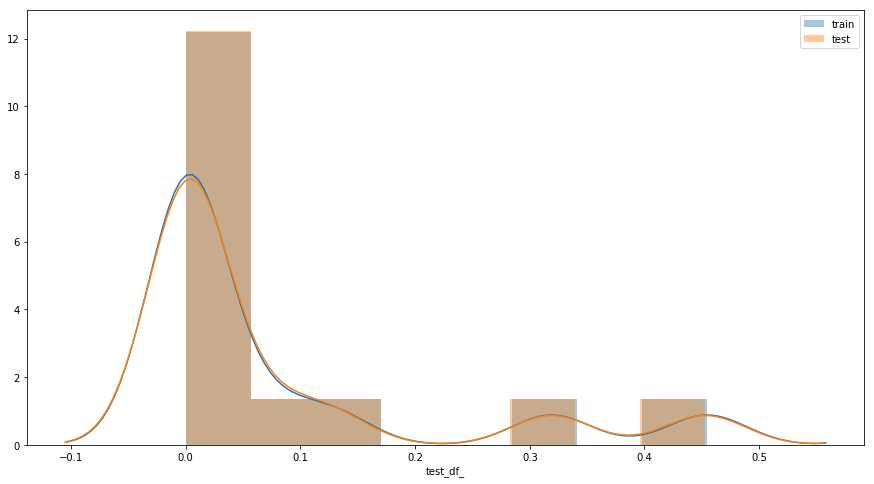



-------------------------------------------------------------------------------------------------------------------------
bathrooms distribution graph


       train_v    test_v      diff
0.00  0.000266  0.000928 -0.000662
0.50  0.000200  0.000155  0.000045
0.75  0.002993  0.004020 -0.001027
1.00  0.177918  0.177025  0.000893
1.25  0.000333  0.000618 -0.000286
1.50  0.067110  0.066327  0.000784
1.75  0.140472  0.141775 -0.001303
2.00  0.090256  0.087199  0.003058
2.25  0.095311  0.092919  0.002392
2.50  0.249285  0.249845 -0.000560
2.75  0.056069  0.052566  0.003503
3.00  0.032790  0.039734 -0.006944
3.25  0.027270  0.027211  0.000059
3.50  0.033921  0.033859  0.000062
3.75  0.007183  0.007267 -0.000083
4.00  0.006651  0.005411  0.001240
4.25  0.003791  0.003401  0.000390
4.50  0.004257  0.005411 -0.001155
4.75  0.001064  0.001082 -0.000018
5.00  0.000931  0.001082 -0.000151
5.25  0.000732  0.000309  0.000422
5.50  0.000466  0.000464  0.000002
5.75  0.000200  0.000155  0.000045
6.00 

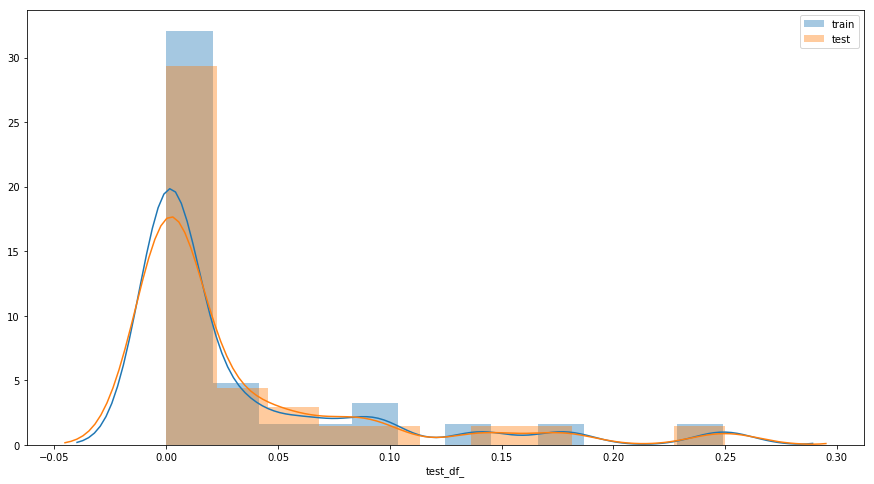



-------------------------------------------------------------------------------------------------------------------------
floors distribution graph


      train_v    test_v      diff
1.0  0.489591  0.502628 -0.013037
2.0  0.386432  0.371985  0.014447
1.5  0.088460  0.087353  0.001107
3.0  0.027735  0.029994 -0.002259
2.5  0.007516  0.007421  0.000095
3.5  0.000266  0.000618 -0.000352


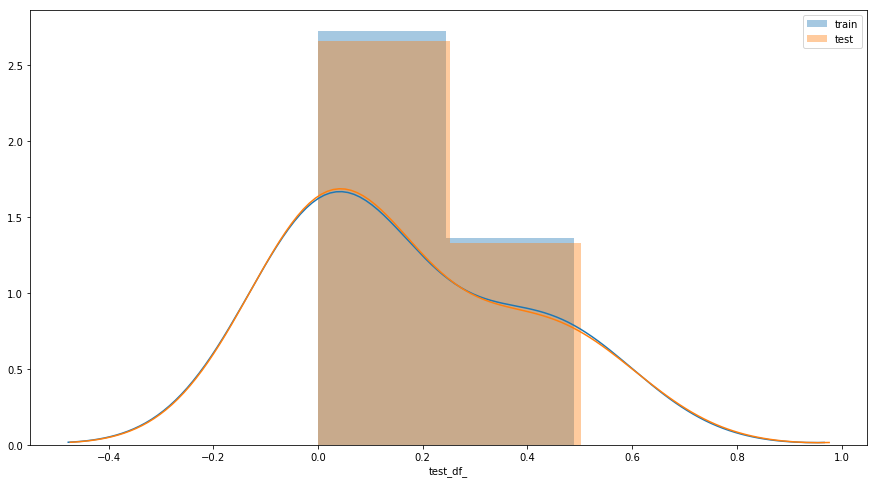



-------------------------------------------------------------------------------------------------------------------------
waterfront distribution graph


    train_v    test_v      diff
0  0.992883  0.991342  0.001541
1  0.007117  0.008658 -0.001541


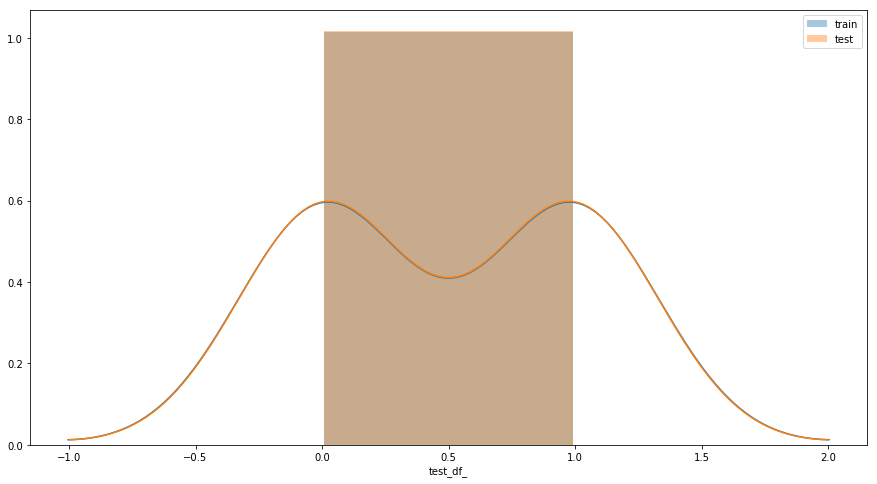



-------------------------------------------------------------------------------------------------------------------------
view distribution graph


    train_v    test_v      diff
0  0.901097  0.902443 -0.001345
1  0.016029  0.014069  0.001960
2  0.044230  0.045918 -0.001688
3  0.024809  0.020717  0.004091
4  0.013834  0.016852 -0.003018


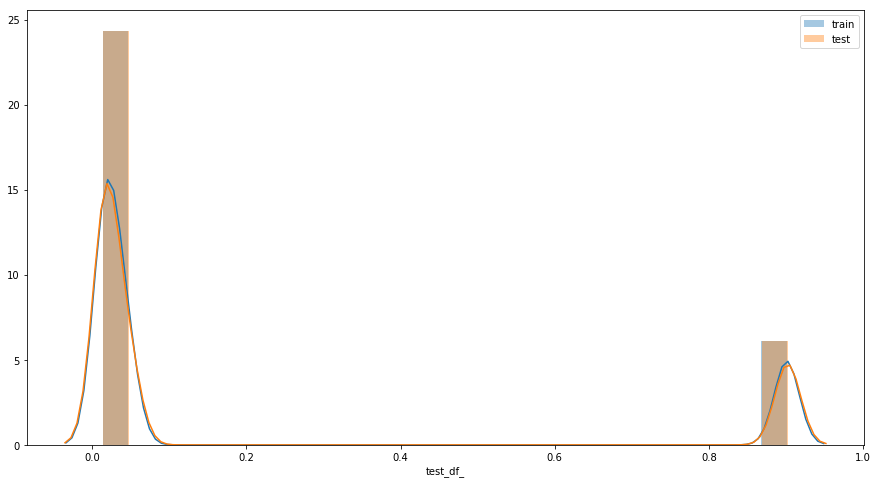



-------------------------------------------------------------------------------------------------------------------------
condition distribution graph


    train_v    test_v      diff
3  0.651347  0.644403  0.006944
4  0.263119  0.262987  0.000132
5  0.076821  0.082560 -0.005740
2  0.007316  0.008813 -0.001496
1  0.001397  0.001237  0.000160


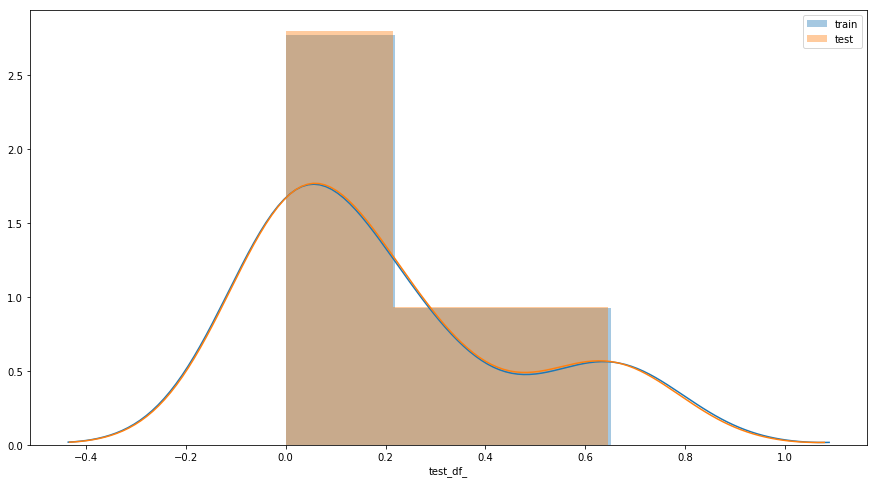



-------------------------------------------------------------------------------------------------------------------------
grade distribution graph


     train_v    test_v      diff
1   0.000067       NaN       NaN
3   0.000133  0.000155 -0.000022
4   0.001530  0.000928  0.000602
5   0.011573  0.009586  0.001987
6   0.093515  0.094465 -0.000950
7   0.414233  0.417594 -0.003361
8   0.279814  0.284941 -0.005127
9   0.123379  0.116574  0.006805
10  0.051945  0.054113 -0.002167
11  0.019155  0.016698  0.002458
12  0.004057  0.004329 -0.000272
13  0.000599  0.000618 -0.000020


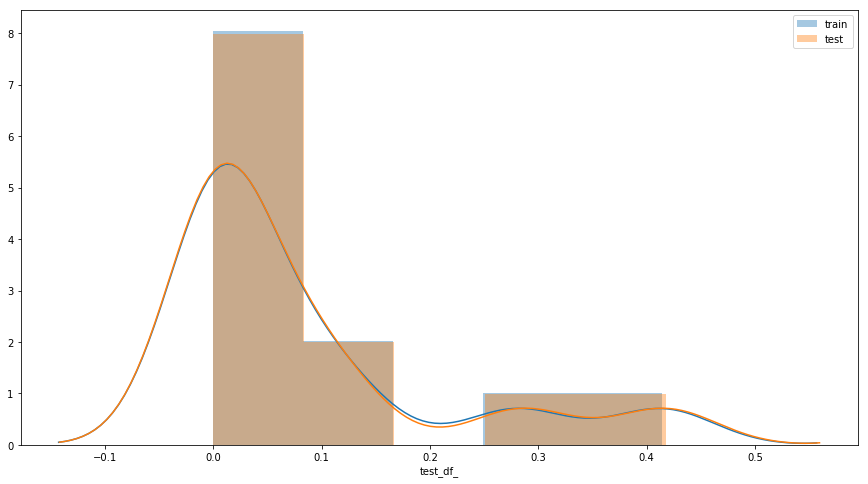



-------------------------------------------------------------------------------------------------------------------------
date distribution graph


                  train_v    test_v      diff
20140502T000000  0.003060  0.003247 -0.000187
20140503T000000  0.000200  0.000155  0.000045
20140504T000000  0.000200  0.000309 -0.000110
20140505T000000  0.004124  0.003401  0.000722
20140506T000000  0.003924  0.003711  0.000214
20140507T000000  0.004390  0.004174  0.000215
20140508T000000  0.003525  0.004329 -0.000804
20140509T000000  0.003991  0.003247  0.000744
20140510T000000  0.000200  0.000309 -0.000110
20140511T000000  0.000133       NaN       NaN
20140512T000000  0.003791  0.003556  0.000235
20140513T000000  0.003525  0.005102 -0.001577
20140514T000000  0.003326  0.004793 -0.001467
20140515T000000  0.003658  0.004174 -0.000516
20140516T000000  0.003525  0.003092  0.000433
20140517T000000  0.000067       NaN       NaN
20140518T000000  0.000200  0.000618 -0.000419
20140519T000000  0.004

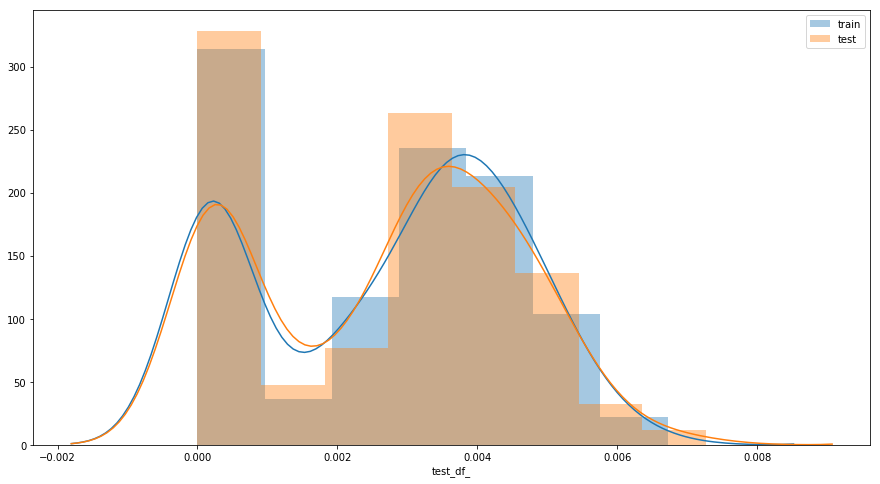

In [383]:
category_col = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade','date']

for i in category_col:
    train_test_diff(train_df, test_df, i)
    category_dist_TT(train_df, test_df, i)

2.Continuity variable
 * sqft_lot, sqft_basement, sqft_lot15는 feature 정규화(log화)가 필요해 보임.
 * sqft_living, sqft_above는 log화 할지 생각해보기.

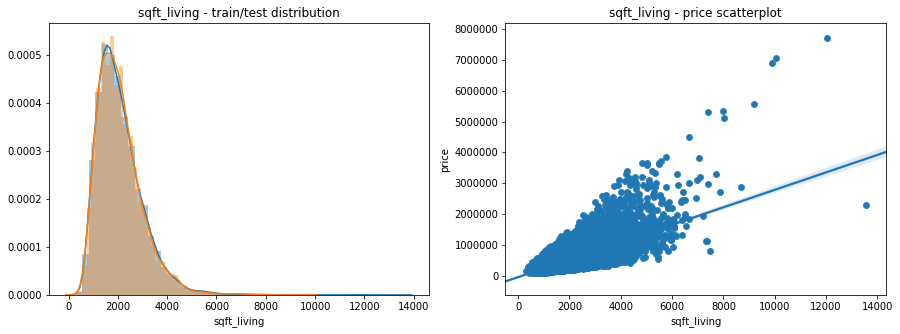

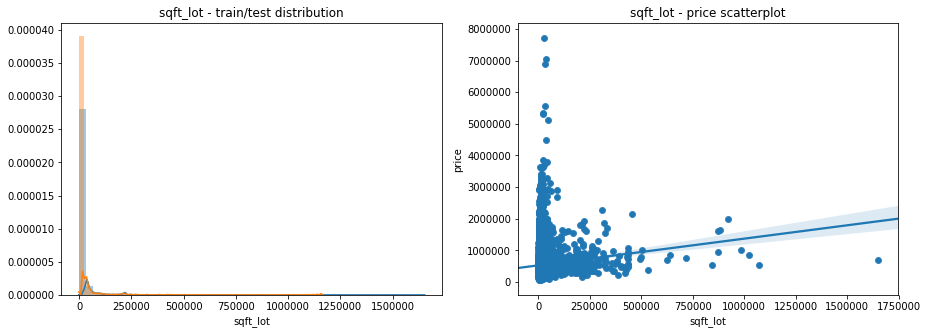

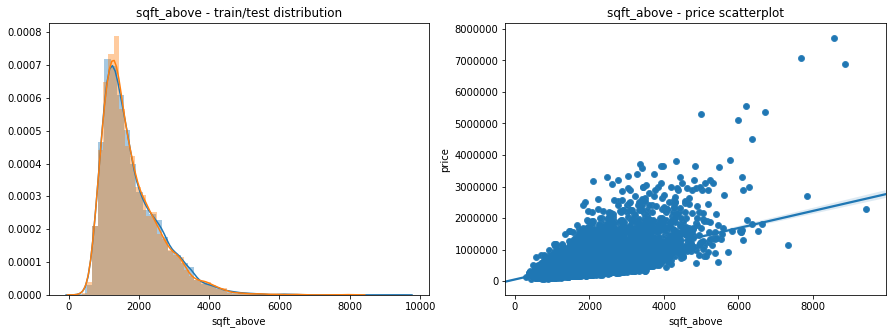

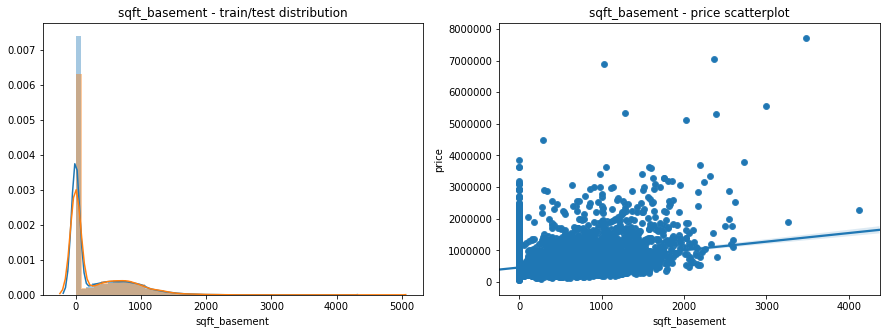

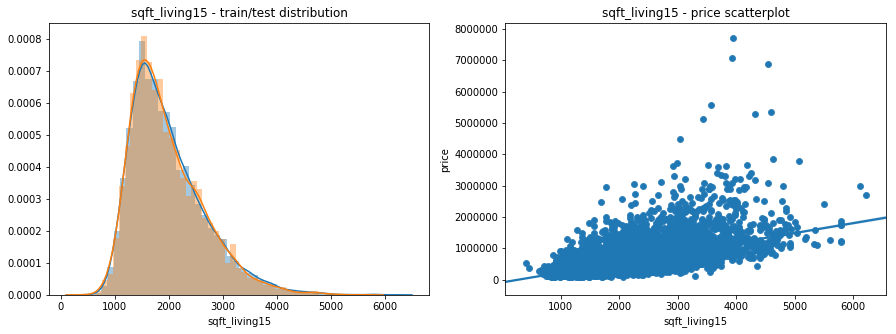

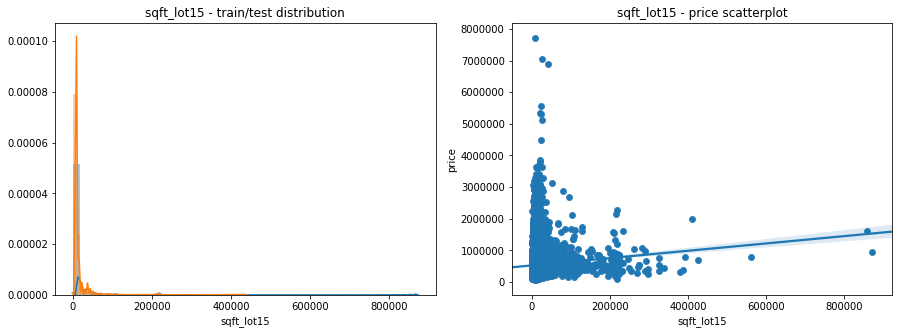

In [385]:
continuous_variable = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']

for col in continuous_variable:
    continous_dist(train_df, test_df, col)

#### Target 값의 분포
* 정규분포 형태의 모양과 맞지 않음 : 비대칭도(왜도)가 큰 경우 log를 적용하면 정규분포 모양에 가까워질 수 있음.


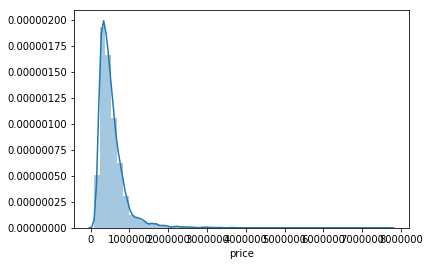

In [386]:
sns.distplot(train_df['price'])

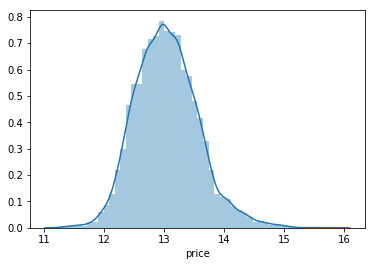

In [388]:
# applied log graph
sns.distplot(np.log1p(train_df['price']))

In [389]:
# log로 바꿈
train_df['price'] = np.log1p(train_df['price'])
train_df['price'].head(3)

0    12.309987
1    12.100718
2    13.142168
Name: price, dtype: float64

#### 시간에 따른 target 값의 변화 : 계절성이 보이진 않음

In [390]:
# 날짜 데이터 datetime 형태로 바꾸기
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

각 날짜의 price 그래프

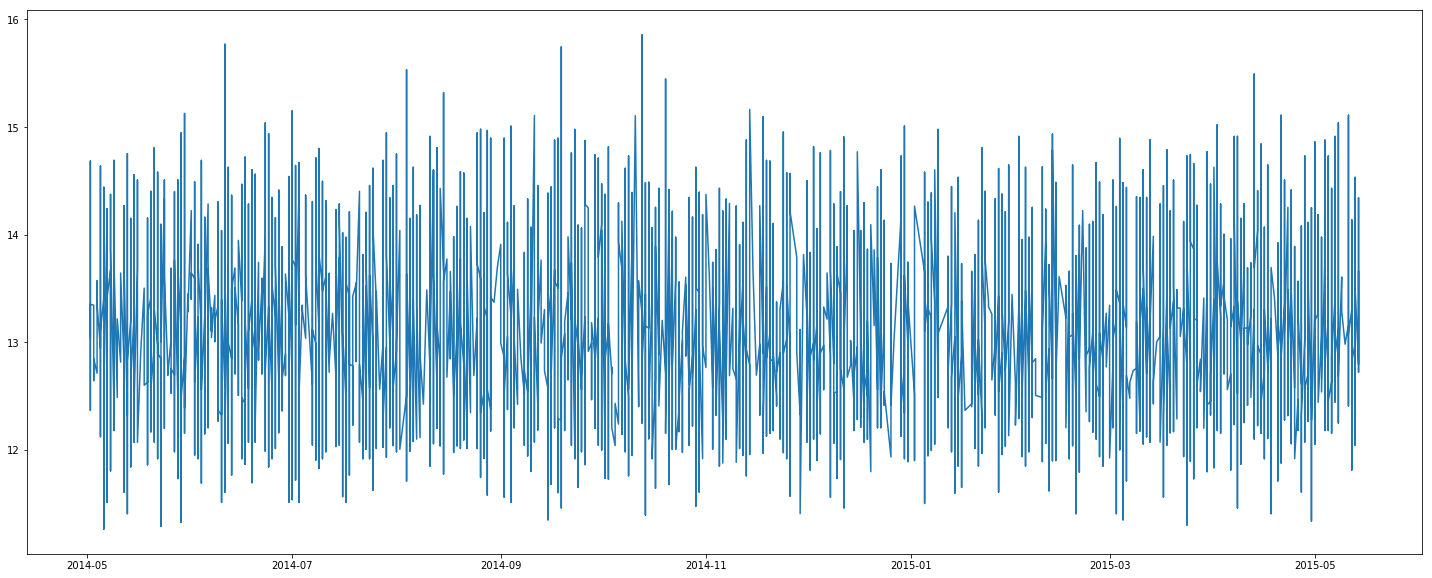

In [392]:
data = train_df[['date','price']].sort_values('date')
data = data.reset_index()
# 1. 전체 : 계절성이 잘 보이진 않음 ->> 좀 더 세부적으로 볾
plt.figure(figsize = (25,10))
plt.plot(data['date'], data['price'])
plt.show()

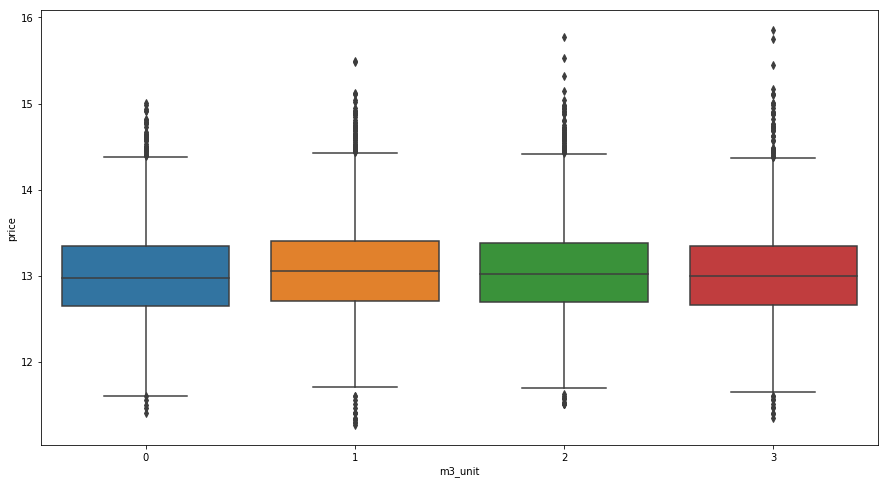

In [394]:
# 1-0. 3개월 단위 boxplot : 3개월 단위로 날짜 끊음.
def m3_apply(x):
    if x.month == 12 or x.month <3:
        return 0
    
    elif x.month < 6:
        return 1
    
    elif x.month < 9:
        return 2
    
    else :
        return 3
    

data['m3_unit'] = data['date'].apply(lambda x : m3_apply(x))
plt.figure(figsize=(15,8))
sns.boxplot(x="m3_unit", y="price", data=data)
plt.show()

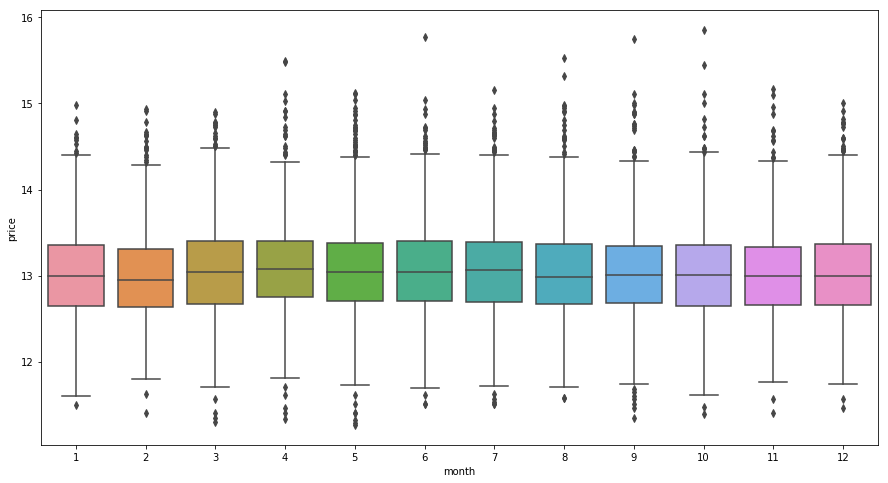

In [395]:
# 1-1. 달 단위 boxplot 그리기 : 1개월 단위로 쪼갬
data['month'] = data['date'].apply(lambda x : x.month)
plt.figure(figsize=(15,8))
sns.boxplot(x="month", y="price", data=data)
plt.show() 

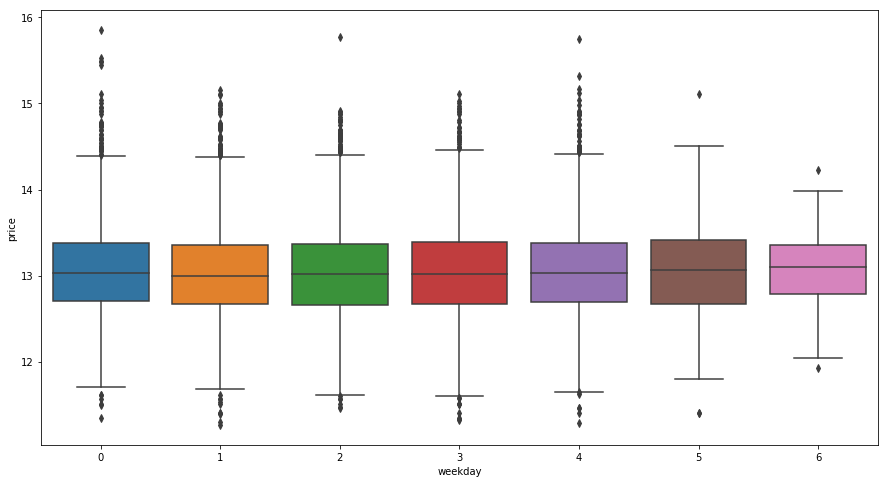

In [397]:
# 1-2. 요일 단위 boxplot 그리기
data['weekday'] = data['date'].apply(lambda x : x.weekday())
plt.figure(figsize=(15,8))
sns.boxplot(x="weekday", y="price", data=data)
plt.show()     

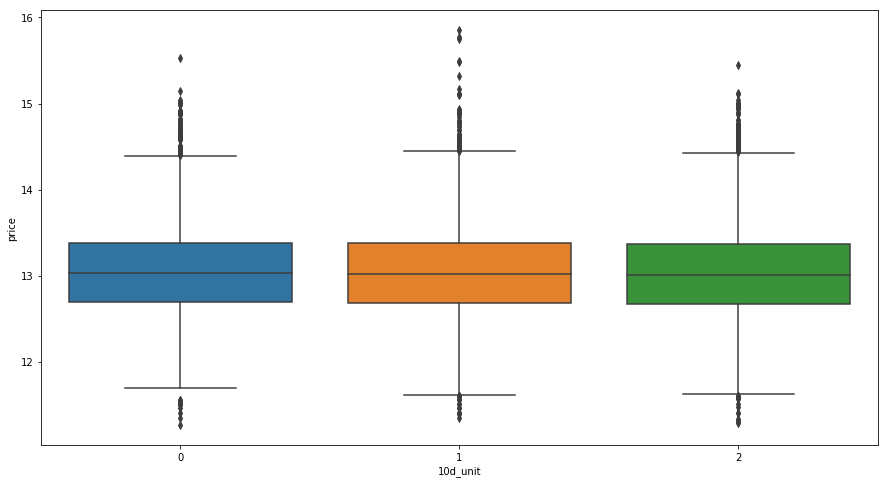

In [398]:
# 1-3. 10일 단위로 끊기
def d10_apply(x):
    
    if x.day < 10:
        return 0
    elif x.day < 20:
        return 1
    else :
        return 2
    
data['10d_unit'] = data['date'].apply(lambda x : d10_apply(x))
plt.figure(figsize=(15,8))
sns.boxplot(x="10d_unit", y="price", data=data)
plt.show()      

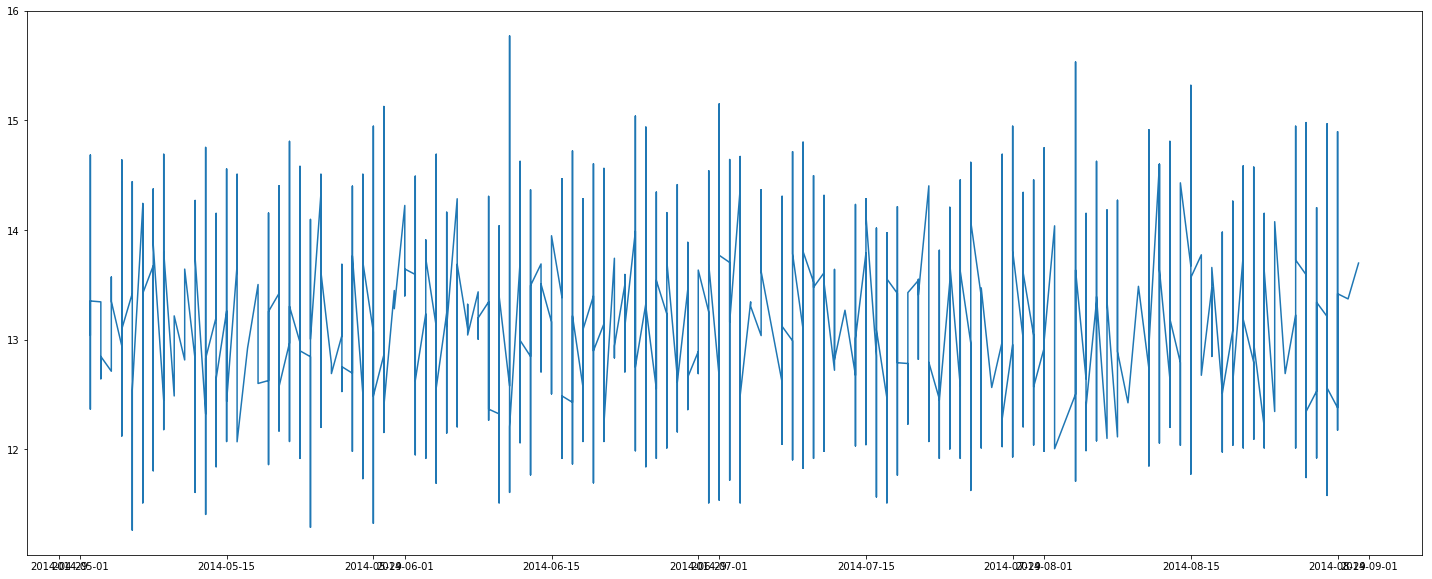

In [400]:
# 2. 3개월만 보기
temp_df = data[(data['date'] >= '2014-05-02') & (data['date'] < '2014-09-01 00:00:00')]
plt.figure(figsize = (25,10))
plt.plot(temp_df['date'], temp_df['price'])
plt.show()

각 날짜별 price의 count, sum, mean, std 보기

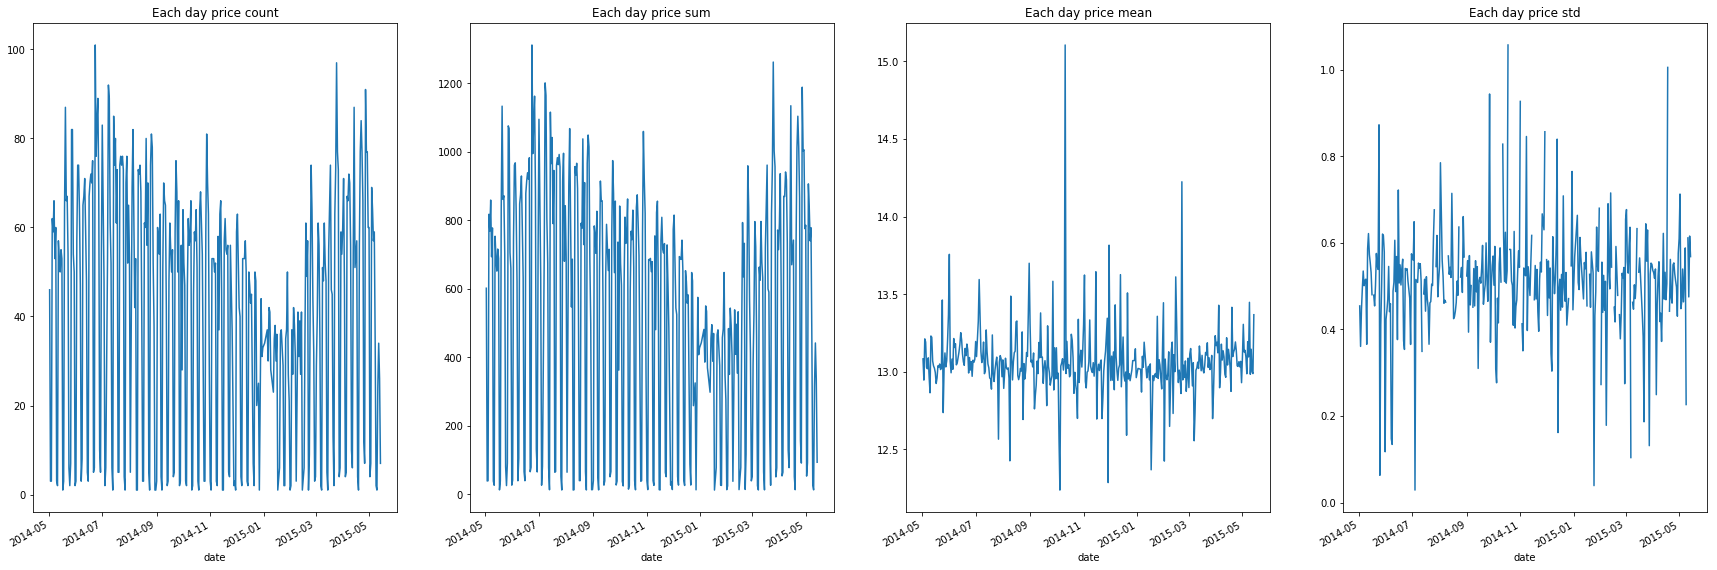

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13311,13311,2014-10-11,15.10612,5,6.0,5490,19897,2.0,0,0,...,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600


In [402]:
fig, ax = plt.subplots(1, 4, figsize=(30,10))
train_df.groupby('date')['price'].count().plot(ax=ax[0])
ax[0].set_title('Each day price count')
train_df.groupby('date')['price'].sum().plot(ax=ax[1])
ax[1].set_title('Each day price sum')
train_df.groupby('date')['price'].mean().plot(ax=ax[2])
ax[2].set_title('Each day price mean')
train_df.groupby('date')['price'].std().plot(ax=ax[3])
ax[3].set_title('Each day price std')
plt.show()

# 급격히 높아진 price mean 부분 : 제거할지 말지 생각해봄.
train_df.loc[train_df['date']==np.argmax(train_df.groupby('date')['price'].mean())]

##### pre-engineering

In [403]:
# category engineering : bathrooms를 7.5 이하로 줄인결과 평균상관계수가 오히려 떨어져서 bedrooms 값만 바꿈.
train_df = train_df.loc[train_df['bedrooms']<=10]

train_df['3u_month'] = train_df['date'].apply(lambda x: m3_apply(x))
temp_dummy = pd.get_dummies(train_df['3u_month'], prefix='m3', drop_first=True)
train_df = pd.concat([train_df, temp_dummy], axis=1)
train_df = train_df.drop(['3u_month'], axis=1)

test_df['3u_month'] = test_df['date'].apply(lambda x: m3_apply(x))
temp_dummy = pd.get_dummies(test_df['3u_month'], prefix='m3', drop_first=True)
test_df = pd.concat([test_df, temp_dummy], axis=1)
test_df = test_df.drop(['3u_month'], axis=1)

# 월 단위 col 넣기
train_df['month'] = train_df['date'].apply(lambda x: x.month)
test_df['month'] = test_df['date'].apply(lambda x: x.month)

### 데이터 engineering
* 각 설명변수와 종속변수와의 관계
* 모델링

#### 각 설명변수와 종속변수와의 관계

1.category variable
 * bedrooms : 선형관계 이룸. 특정 숫자 이상으로 올라가면 가격에서 큰 차이 없음.
 * bathrooms : 상당한 선형관계를 이룸. 6.25, 7.5, 7.75이 직선과 다른 패턴으로 나타남
 * floor : 살짝 선형 관계가 있긴하나 큰 차이 없음.
 * waterfront : 있을 때와 없을 때 차이 있음
 * view : 살짝 선형 관계 있음.
 * condition : 살짝 선형 관계 있음.
 * grade : price와 상당히 높은 선형관계 이룸. 3이 다른 변수에 비해 첨도가 높음.

0.35717157658779153


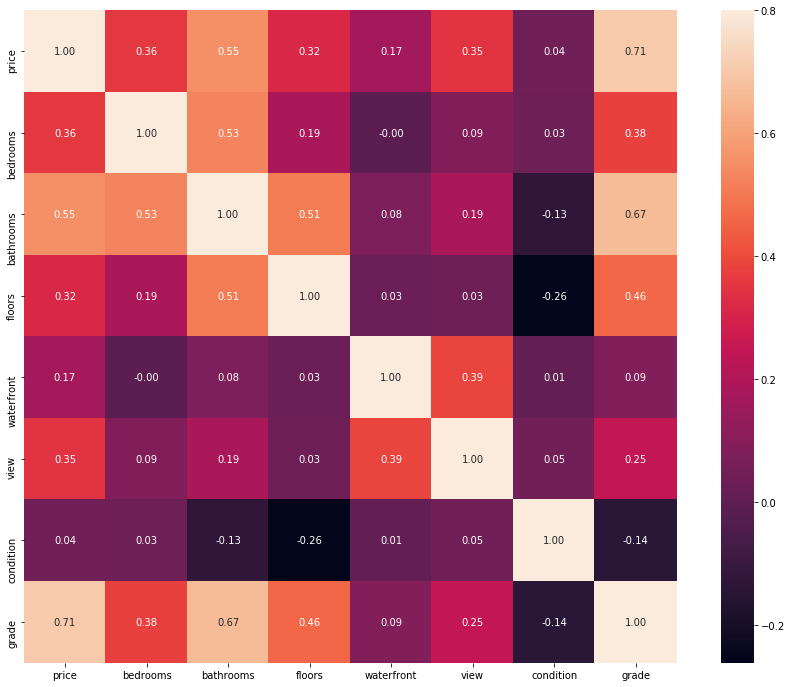

In [404]:
category_variable = ['price','bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

# 상관관계
corrmat = train_df.loc[:,category_variable].corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt=".2f");

# 평균 상관관계 계수
print(corrmat.iloc[0,1:].mean())



--------------------------------------------------------------
bedrooms distribution


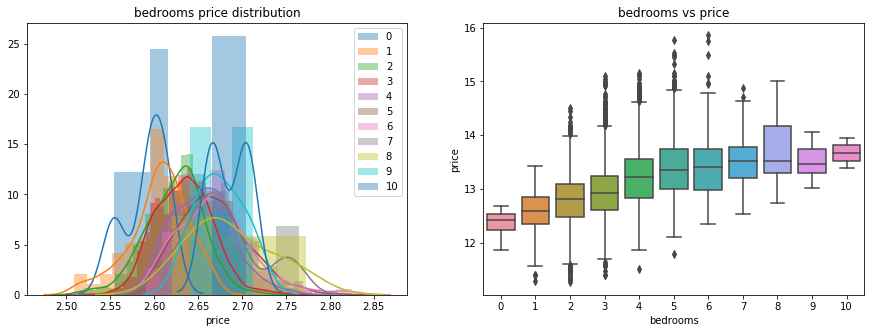



--------------------------------------------------------------
bathrooms distribution


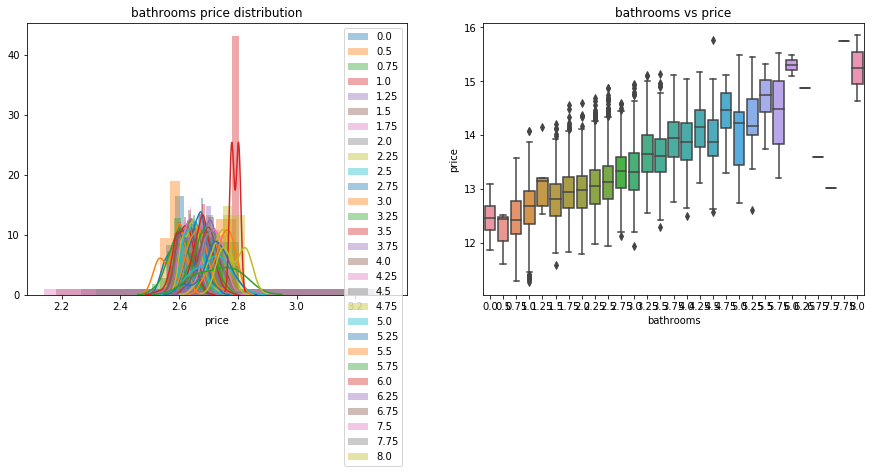



--------------------------------------------------------------
floors distribution


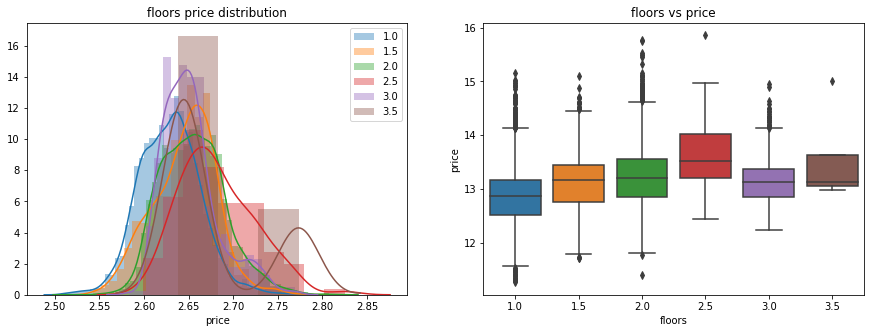



--------------------------------------------------------------
waterfront distribution


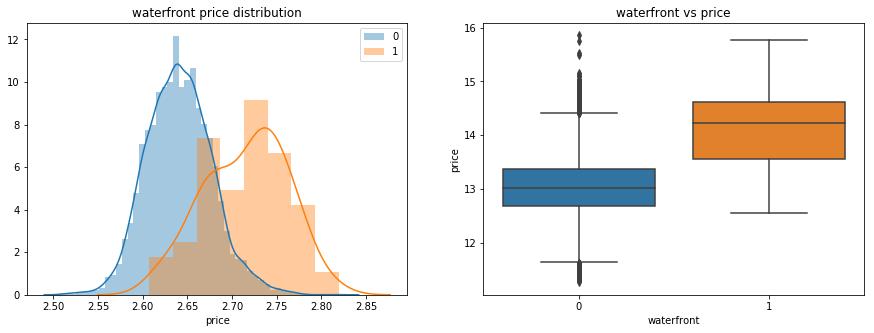



--------------------------------------------------------------
view distribution


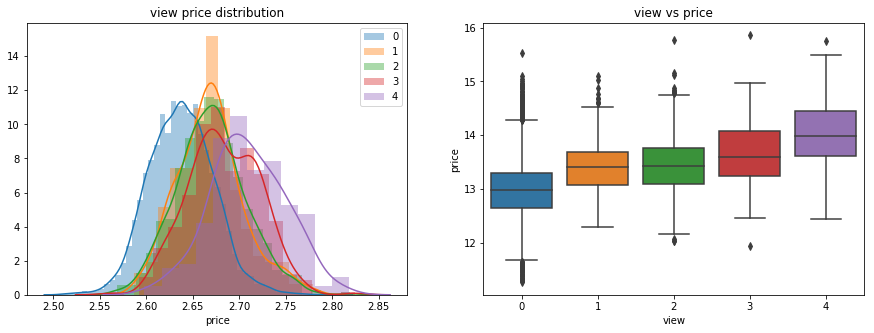



--------------------------------------------------------------
condition distribution


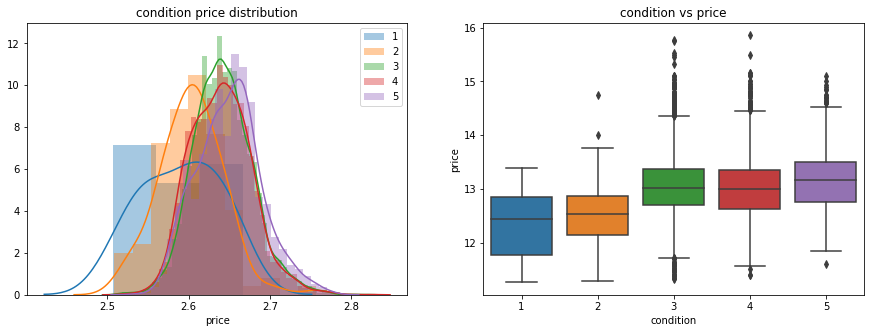



--------------------------------------------------------------
grade distribution


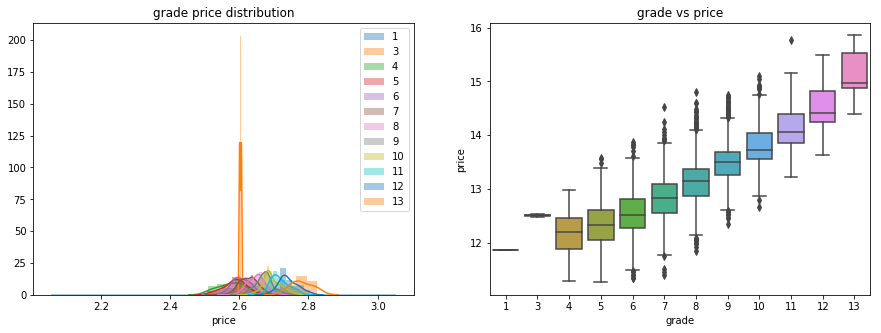

In [405]:
not_in_price_category_variable = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
for col in not_in_price_category_variable:
    category_dist(train_df, col)

In [406]:
# 이상치 1
    # grade가 3인데 price가 지나치게 높은 값들 있음. -> 제거
print(train_df.loc[(train_df['price']>12) & (train_df['grade'] == 3)])
train_df.drop(train_df.loc[(train_df['price']>12) & (train_df['grade'] == 3)].index, inplace=True)


        id       date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2302  2302 2015-02-25  12.476104         1       0.75          520     12981   
4123  4123 2014-11-04  12.542548         1       0.00          600     24501   

      floors  waterfront  view  ...    yr_renovated  zipcode      lat  \
2302     1.0           0     0  ...               0    98022  47.2082   
4123     1.0           0     0  ...               0    98045  47.5316   

         long  sqft_living15  sqft_lot15  m3_1  m3_2  m3_3  month  
2302 -121.995           1340       12233     0     0     0      2  
4123 -121.749            990       22549     0     0     1     11  

[2 rows x 25 columns]


In [407]:
# 이상치 2
    # 중요 변수인 grade, sqft_가 낮음에도 가격이 높음
index_num = train_df.loc[(train_df['price']>14.7) & (train_df['grade'] == 8)].index.tolist()[0]
check_proportion(train_df, ['price','bedrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15'], index_num)
# -> 제거
train_df.drop(index_num, inplace=True)

price : 0.7717965307067418
bedrooms : 0.5
sqft_living : 0.29735849056603775
sqft_lot : 0.016219025598498703
floors : 0.4
view : 1.0
condition : 0.5
grade : 0.5833333333333334
sqft_above : 0.3223684210526316
sqft_basement : 0.24213075060532688
sqft_living15 : 0.38908965754603336
sqft_lot15 : 0.030605973931392718


In [408]:
index_num = train_df.loc[(train_df['price']>15.5) & (train_df['grade'] == 11)].index.tolist()[0]
check_proportion(train_df, ['price','bedrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15'], index_num)
# -> 제거
train_df.drop(index_num, inplace=True)

price : 0.9811810890775089
bedrooms : 0.5
sqft_living : 0.7358490566037735
sqft_lot : 0.02229472407666647
floors : 0.4
view : 0.5
condition : 0.5
grade : 0.8333333333333334
sqft_above : 0.8103070175438597
sqft_basement : 0.5714285714285714
sqft_living15 : 0.6076406814661848
sqft_lot15 : 0.028485472960166517


2.continuous variable
 * sqft_living : price와 상당한 선형관계를 이룸 -> sqft_living이 14000인 데이터 삭제 고민, log로 바꿀지 고민
 * sqft_lot : 분포 자체가 비대칭이 크고 price와 선형도가 거의 없음. -> log화 시킴.
 * sqft_above : 상당한 선형관계 있음 -> log화 할지 고민.
 * sqft_basement : log화 필요
 * sqft_living15 : price와 상당한 선형관계를 이룸. -> log로 바꿀지 고민
 * sqft_lot15 : 분포 자체가 비대칭이 크고 price와 선형도가 거의 없음. -> log화 시킴.

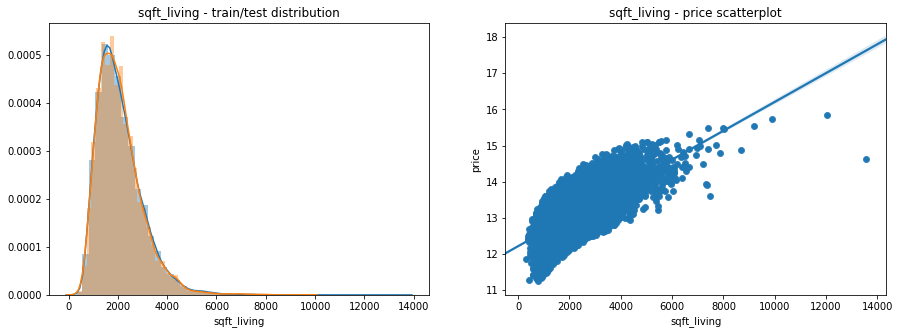

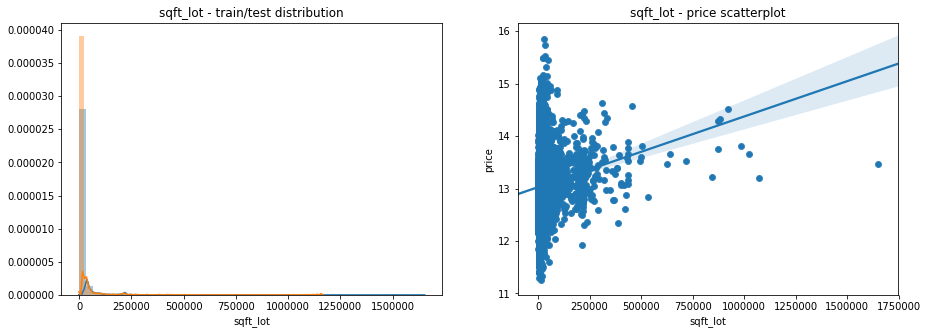

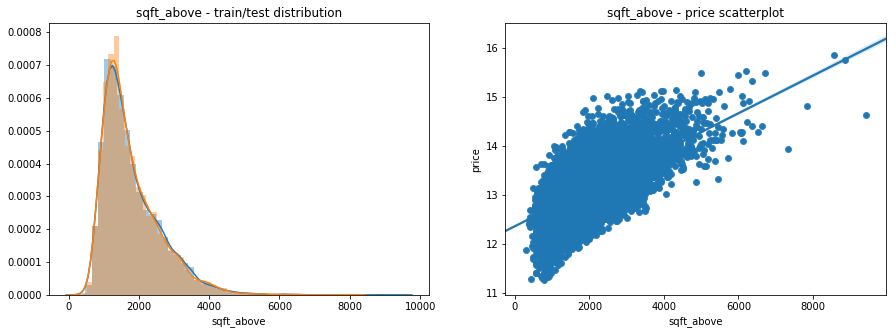

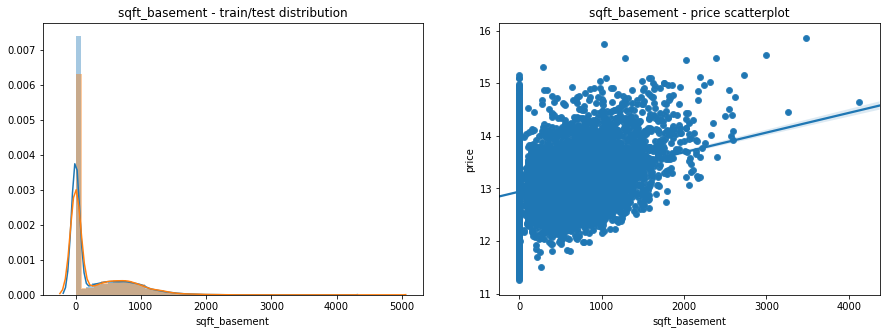

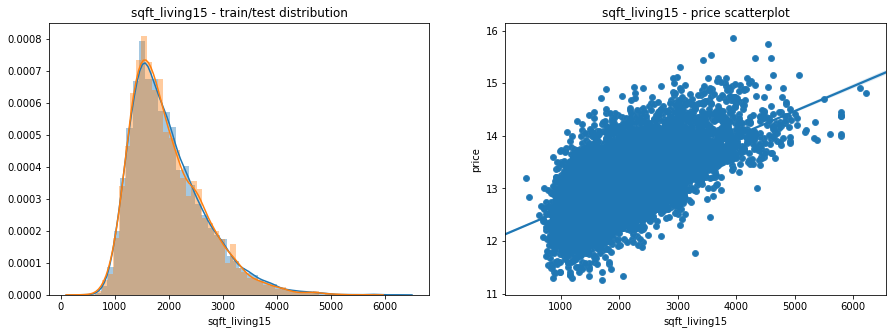

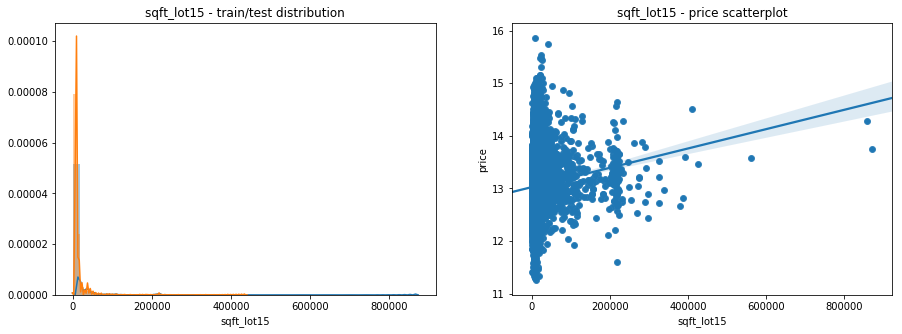

In [409]:
for col in continuous_variable:
    continous_dist(train_df, test_df, col)

    2-1. 이상치 제거

In [410]:
index_num = train_df['sqft_living'].idxmax()
check_proportion(train_df, ['price','bedrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15'], index_num)

# 삭제
train_df.drop(8912, inplace=True)
train_df = train_df.reset_index(drop=True)

price : 0.734978824525319
bedrooms : 0.7
sqft_living : 1.0
sqft_lot : 0.18610657974520833
floors : 0.8
view : 1.0
condition : 0.5
grade : 0.9166666666666666
sqft_above : 1.0
sqft_basement : 1.0
sqft_living15 : 0.7659611082429875
sqft_lot15 : 0.24943914702101777


log 전 상관관계

0.40687359235019405


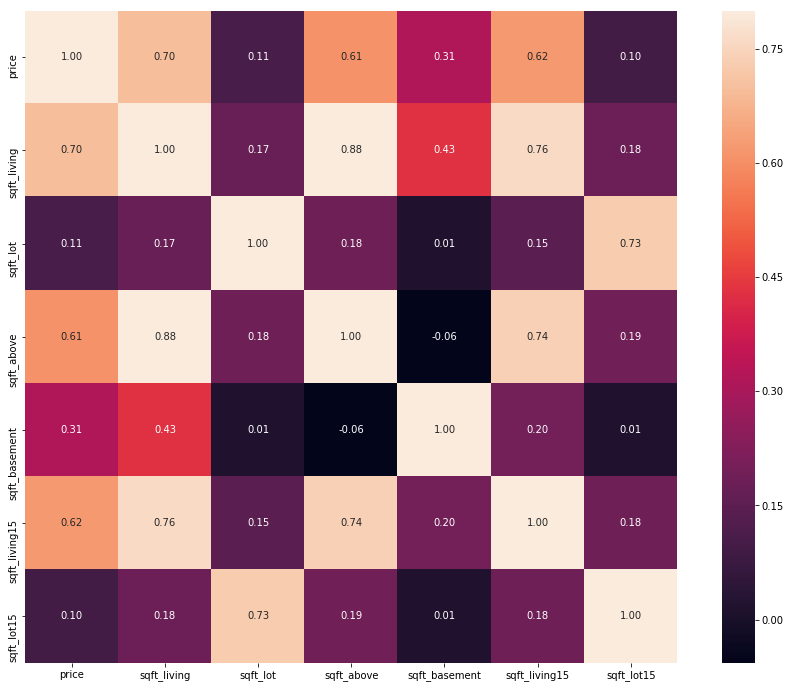

In [411]:
with_price_continuous_variable = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']

# 상관관계
corrmat = train_df.loc[:,with_price_continuous_variable].corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt=".2f");

# 평균 상관관계 계수
print(corrmat.iloc[0,1:].mean())

log 후 상관관계

0.41825276893009455


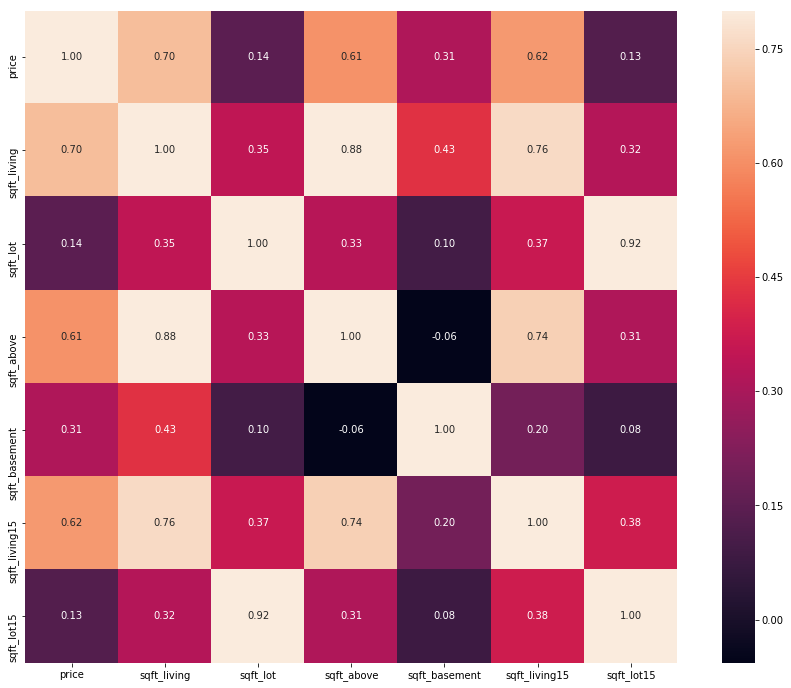

In [412]:
# 상관관계 : lot만 계수가 높아지므로 lot에다가만 log 넣기
trans_log_variable = ['sqft_lot','sqft_lot15']
temp_df = train_df.copy()
temp_df = temp_df.loc[:,with_price_continuous_variable]
temp_df.loc[:,trans_log_variable] = np.log1p(temp_df.loc[:,trans_log_variable])
temp_df.fillna(0, inplace=True)

corrmat = temp_df.loc[:,with_price_continuous_variable].corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt=".2f");

# 평균 상관관계 계수
print(corrmat.iloc[0,1:].mean())

3.위치변수 : 위치변수를 나누는 방법은 여러 가지가 있음 -> 나중에 모델링 부분에서 어떤 방법을 쓸지 정함.
 * 구획으로 나눠서 계산.
 * clustering -> 가격 따라서 해보기.
 * PCA : 차원 변화 주지 않기, 변화 주기.

구획으로 나눠서 계산

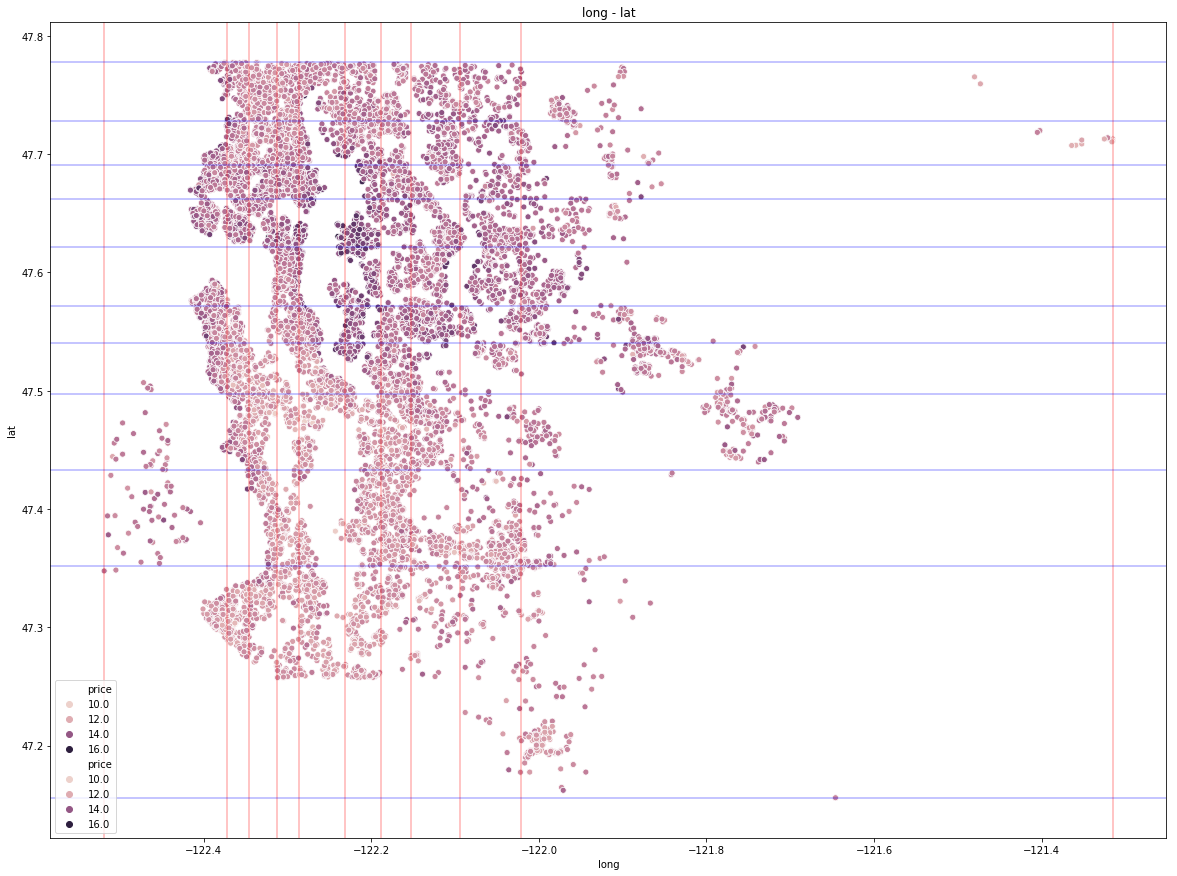

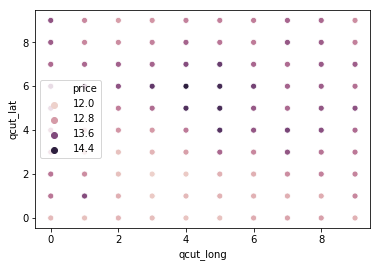

In [413]:
plt.figure(figsize=(20,15))
sns.scatterplot('long','lat',hue='price',data=train_df)
scatter_quantile_visualize(train_df, 'long', 'lat')

qcut_count = 10
# pd.qcut : quantile 기준, 갯수가 똑같은 구간으로 나눔. labels : 레이블 번호 넣음.
train_df['qcut_long'] = pd.qcut(train_df['long'], qcut_count, labels=range(qcut_count))
train_df['qcut_lat'] = pd.qcut(train_df['lat'], qcut_count, labels=range(qcut_count))
test_df['qcut_long'] = pd.qcut(test_df['long'], qcut_count, labels=range(qcut_count))
test_df['qcut_lat'] = pd.qcut(test_df['lat'], qcut_count, labels=range(qcut_count))
temp = train_df.groupby(['qcut_long','qcut_lat'])['price'].mean().reset_index()
sns.scatterplot('qcut_long','qcut_lat', hue='price', data=temp);

In [414]:
# 타입 int로 바꿔주기
train_df['qcut_long'] = train_df['qcut_long'].astype('int')
train_df['qcut_lat'] = train_df['qcut_lat'].astype('int')

test_df['qcut_long'] = test_df['qcut_long'].astype('int')
test_df['qcut_lat'] = test_df['qcut_lat'].astype('int')

clustering으로 해보기 : 클러스터를 3개로 나눔.

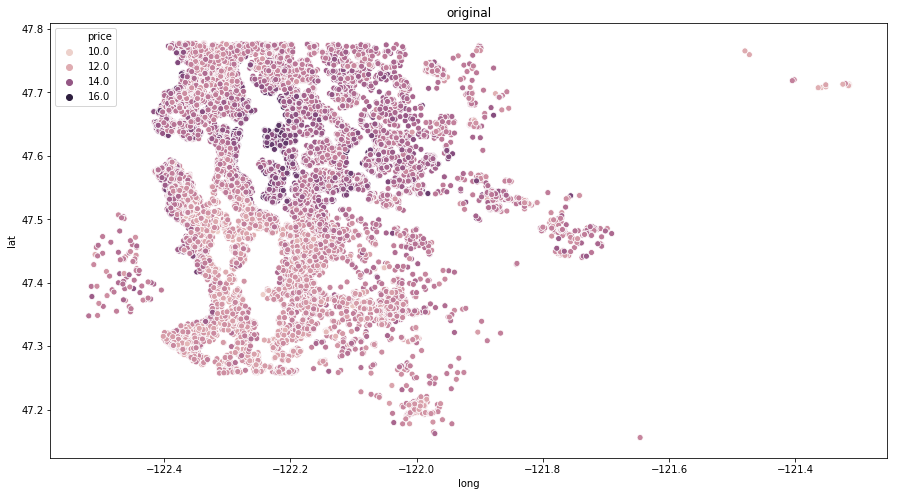

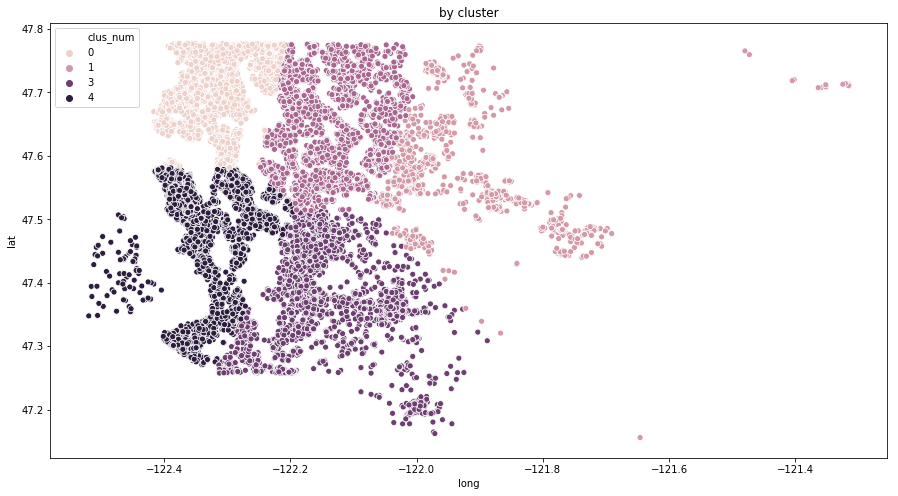

In [415]:
geo_feature = ['lat', 'long']
geo_df = train_df[['lat', 'long']]
kmeans = KMeans(n_clusters=5, random_state=0).fit(train_df[['lat', 'long']])


geo_df['clus_num'] = kmeans.labels_
geo_df['price'] = train_df['price']
plt.figure(figsize=(15,8))
plt.title('original')
sns.scatterplot('long','lat', hue='price', data=geo_df)
plt.show()

plt.figure(figsize=(15,8))
plt.title('by cluster')
sns.scatterplot('long','lat', hue='clus_num', data=geo_df)
plt.show()

train_df['kclus_num'] = geo_df['clus_num']
test_df['kclus_num'] = kmeans.predict(test_df[['lat','long']])

In [416]:
pca.transform(test_df[['lat', 'long']])

array([[-0.1839286 ],
       [-0.11093827],
       [ 0.09757148],
       ...,
       [-0.15967487],
       [-0.08681647],
       [ 0.12737054]])

PCA

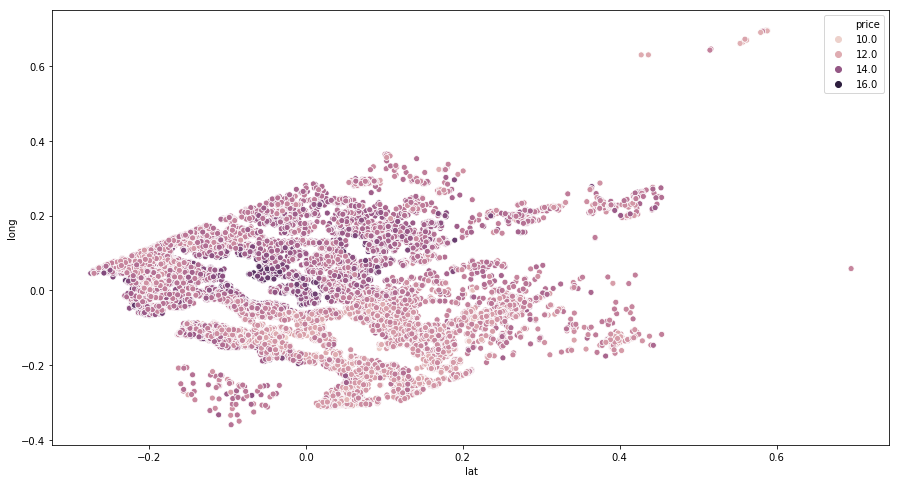

In [417]:
# 차원 : 2 -> 2
from sklearn.decomposition import PCA

geo_feature = ['lat', 'long']
geo_df = train_df[['lat', 'long']]

pca = PCA(n_components=2).fit(geo_df)
result = pca.transform(geo_df)
result_df = pd.DataFrame({'lat':result[:,0], 'long':result[:,1], 'price':train_df['price']})
train_pca2 = pca.transform(train_df[['lat', 'long']])
test_pca2 = pca.transform(test_df[['lat', 'long']])
train_df['pca2_lat']= train_pca2[:,0]
train_df['pca2_long'] = train_pca2[:,1]
test_df['pca2_lat']= test_pca2[:,0]
test_df['pca2_long'] = test_pca2[:,1]

plt.figure(figsize=(15,8))
sns.scatterplot('lat','long', hue='price', data=result_df)
plt.show()

# 차원 : 2 -> 1
geo_feature = ['lat', 'long']
geo_df = train_df[['lat', 'long']]

pca = PCA(n_components=1).fit(geo_df)
result = pca.transform(geo_df)
result_df = pd.DataFrame({'one_dimen':result[:,0], 'price':train_df['price']})
train_df['pca1'] = pca.transform(train_df[['lat', 'long']])
test_df['pca1'] = pca.transform(test_df[['lat', 'long']])

In [418]:
train_pca2[:,0]

array([-0.00098227, -0.12924954,  0.09246701, ..., -0.1904954 ,
       -0.08075931, -0.0866225 ])

#### 모델링

* 변수정리 : 1차로 변수 그대로 일 때 모델을 돌려봄
 * Linear Regression
 * Regression Tree
 * xgboost

Linear Regression

In [419]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [420]:
print(train_df.columns)
target_cols = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15', 'm3_1', 'm3_2', 'm3_3', 'lat','long']

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'm3_1', 'm3_2', 'm3_3',
       'month', 'qcut_long', 'qcut_lat', 'kclus_num', 'pca2_lat', 'pca2_long',
       'pca1'],
      dtype='object')


In [421]:
# statsmodels
X_train = train_df[target_cols] 
X_test = test_df[target_cols]

y_train = train_df['price']
X_train = sm.add_constant(X_train) # adding a constant
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     2667.
Date:                Sat, 11 May 2019   Prob (F-statistic):               0.00
Time:                        21:35:57   Log-Likelihood:                -597.24
No. Observations:               15030   AIC:                             1234.
Df Residuals:                   15010   BIC:                             1387.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -52.9480      2.377    -22.278      0.000     -57.607     -48.289
bedrooms         -0.0111      0.003     -3.720      0.000      -0.017      -0.005
bathrooms         0.0678      0.005     13.773      0.000       0.058       0.077
sqft_living    9.728e-05   3.46e-06     28.157      0.000    9.05e-05       0.000
sqft_lot       4.939e-07    7.1e-08      6.960      0.000    3.55e-07    6.33e-07
floors            0.0714      0.005     13.199      0.000       0.061       0.082
waterfront        0.3321      0.027     12.340      0.000       0.279       0.385
view              0.0605      0.003     18.986      0.000       0.054       0.067
condition         0.0708      0.004     19.983      0.000       0.064       0.078
grade             0.1625      0.003     50.448      0.000       0.156       0.169
sqft_above     3.928e-05   3.42e-06     11.499      0.000    3.26e-05     4.6e-05
sqft_basement    5.8e-05   3.99e-06     14.554      0.000    5.02e-05    6.58e-05
yr_built         -0.0032      0.000    -29.112      0.000      -0.003      -0.003
yr_renovated   4.056e-05   5.51e-06      7.361      0.000    2.98e-05    5.14e-05
sqft_living15  9.724e-05   5.14e-06     18.907      0.000    8.72e-05       0.000
sqft_lot15    -2.193e-07    1.1e-07     -1.994      0.046   -4.35e-07    -3.7e-09
m3_1              0.0515      0.006      8.234      0.000       0.039       0.064
m3_2              0.0090      0.006      1.436      0.151      -0.003       0.021
m3_3              0.0002      0.007      0.038      0.970      -0.013       0.013
lat               1.3432      0.016     85.069      0.000       1.312       1.374
long             -0.0499      0.018     -2.798      0.005      -0.085      -0.015
==============================================================================
Omnibus:                      240.763   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              475.963
Skew:                          -0.016   Prob(JB):                    4.43e-104
Kurtosis:                       3.871   Cond. No.                     1.52e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

다중공선성 체크